Import libraries and data

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')

R2 variable selection function

In [27]:
def pls_r2_variable_selection(X, y, V):
    """
    Perform R2 score-based variable selection for PLS.
    
    Parameters:
    X : numpy array, shape (n_samples, n_features)
        The input data matrix.
    y : numpy array, shape (n_samples,)
        The target variable.
    V : int
        The desired number of variables to be selected.
    
    Returns:
    s : list
        Indices of the selected features, sorted by selection order.
    """

    
    n, m = X.shape
    s = []  # Selected variables
    s_names= []
    R2_out = []
    sn = list( X.columns.values )  # Unselected variables
    N = 0  # Number of selected variables
    M = m  # Number of unselected variables
    
    X = X.values
    y = y.values
    
    # Standardize X and y
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    for v in tqdm( range(V) ):
        TSS = np.sum((y_scaled - np.mean(y_scaled))**2)
        R2_values = []
        
        for i, m in enumerate(sn):
            s_temp = s + [i]
            X_temp = X_scaled[:, s_temp]
            
            # Calibrate PLS model
            pls = PLSRegression(n_components=min(len(s_temp), 4))  # Limit components to avoid overfitting
            pls.fit(X_temp, y_scaled)
            
            # Estimate y from the model
            y_pred = pls.predict(X_temp).flatten()
            
            # Calculate RSS and R2
            RSS = np.sum((y_scaled - y_pred)**2)
            R2 = 1 - RSS / TSS
            # print( R2 )
            R2_values.append(R2)
        
        # print( v, " ", len( R2_values  ) )
        # Select the variable with the highest R2
        idx = np.argmax(R2_values)
        R2_out.append(R2_values[idx])
        s.append(idx)
        s_names.append(sn[idx])
        sn.pop(idx)
        N += 1
        M -= 1
    
    return s, np.array(R2_out), s_names


Running the variable selection

In [28]:
V = 100     # Number of variables
selected_features, R2_values, s_names = pls_r2_variable_selection(X_cal, Y_cal, V)

100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


[21, 23, 148, 22, 24, 63, 1, 28, 38, 116, 134, 39, 46, 51, 104, 21, 26, 14, 29, 123, 3, 15, 14, 33, 34, 21, 1, 112, 16, 12, 46, 32, 29, 21, 56, 25, 55, 25, 17, 111, 111, 47, 1, 1, 16, 1, 16, 33, 33, 16, 59, 21, 15, 14, 16, 47, 33, 1, 16, 33, 33, 16, 33, 16, 33, 16, 34, 33, 16, 21, 33, 16, 16, 33, 16, 38, 16, 38, 37, 21, 33, 22, 5, 23, 15, 21, 14, 53, 18, 21, 14, 18, 14, 2, 12, 14, 47, 14, 47, 14]


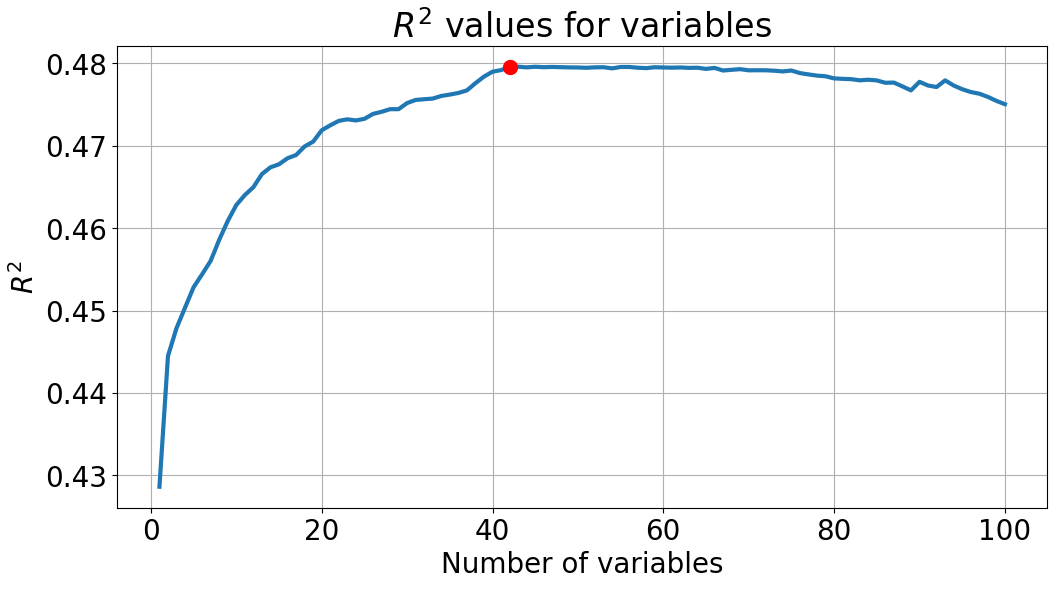

In [29]:
fig = plt.figure(figsize=(12, 6))
    
TITLEFONT = 24
AXISFONT = 20
LEGENDFONT = 18

plt.rc('xtick', labelsize=AXISFONT)
plt.rc('ytick', labelsize=AXISFONT)

plt.plot( range(1, 101), R2_values[:100], "-",linewidth=3 )
plt.plot(42,R2_values[42],'ro',markersize=10)
plt.plot
plt.grid()
plt.title( r"$R^2$ values for variables",fontsize=TITLEFONT )
plt.ylabel( r"$R^2$",fontsize=AXISFONT )
plt.xlabel("Number of variables", fontsize=AXISFONT)

print( selected_features )

X_cal.columns[selected_features]


df = pd.DataFrame({'Column':s_names,'Cumulative R2':R2_values})

In [30]:
df.to_csv('variables.csv')

df

,Column,Cumulative R2
0,% Silica Concentrate Lag 1,0.428627
1,% Silica Concentrate Lag 4,0.444504
2,Flotation Column 07 Level Lag 4,0.447877
3,% Silica Concentrate Lag 3,0.450375
4,% Iron Feed Lag 1,0.452848
...,...,...
95,Flotation Column 03 Air Flow Lag 2,0.476537
96,Flotation Column 05 Level Lag 4,0.476332
97,Flotation Column 04 Air Flow Lag 6,0.475948
98,Flotation Column 06 Level Lag 1,0.475465
